In [1]:
# ╔═════════════════════════════════════════════════════════════════════╗
# ║  📦  CELDA 0  –  UTILIDADES RÁPIDAS                                 ║
# ╚═════════════════════════════════════════════════════════════════════╝
from pathlib import Path
import pandas as pd, numpy as np, re, json, joblib, warnings, itertools
import matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")

def _safe_glob(p:Path, pat:str):
    try:
        return list(p.glob(pat))
    except Exception:
        return []

def discover_rfe_steps(run_dir:Path):
    """Devuelve dict num_canales  ➜  Path(ablation_full_*) ya finalizado"""
    pats = sorted(run_dir.glob("ablation_full_*"),
                  key=lambda p:int(re.search(r"\d+$",str(p)).group()), reverse=True)
    return {int(p.name.split("_")[-1]): p for p in pats}

def load_metrics_csv(step_dir:Path):
    """Devuelve DF de métricas baseline o None si aún no existe."""
    _candidates = _safe_glob(step_dir, "all_folds_metrics_MULTI_*.csv")
    return pd.read_csv(_candidates[0]) if _candidates else None

def summarise_baseline(df, metric:str):
    if df is None or df.empty:
        return np.nan
    return df.groupby("classifier")[metric].mean().mean()


In [2]:
# ╔═════════════════════════════════════════════════════════════════════╗
# ║  📊  CELDA 1 – RECONSTRUIR EL TABLERO RFE «ON THE FLY»              ║
# ╚═════════════════════════════════════════════════════════════════════╝
BASE_RUN_DIR = Path("./runs/3_folds_ablation")   # cambia si es necesario
SCORING_FALLBACK = "balanced_accuracy"           # por si aún no existe rfe_summary.csv

# 1) Qué pasos existen (terminados o en curso)
step_map = discover_rfe_steps(BASE_RUN_DIR)
if not step_map:
    raise RuntimeError("⚠️ No se encontró ninguna carpeta ablation_full_* aún.")

# 2) Leer rfe_summary si ya está, si no lo regeneramos «en vivo»
rfe_summary_path = BASE_RUN_DIR / "rfe_summary.csv"
if rfe_summary_path.exists():
    rfe_df = pd.read_csv(rfe_summary_path).sort_values("num_channels", ascending=False)
    scoring_metric = rfe_df.columns[1]
else:
    # reconstruir provisionalmente para lo ya terminado
    scoring_metric = SCORING_FALLBACK
    rows = []
    for k, p in step_map.items():
        base_df = load_metrics_csv(p)
        if base_df is None:          # aún entrenando
            continue
        rows.append({"num_channels": k,
                     scoring_metric: summarise_baseline(base_df, scoring_metric),
                     "channels_in_baseline": "?"})
    rfe_df = pd.DataFrame(rows).sort_values("num_channels", ascending=False)

display(rfe_df.head())


,num_channels,auc_bal07,channels_in_baseline
0,6,0.798252,"DistanceCorr, MI_KNN_Symmetric, Pearson_Full_F..."
1,5,0.795025,"DistanceCorr, MI_KNN_Symmetric, Pearson_Full_F..."
2,4,0.815418,"DistanceCorr, MI_KNN_Symmetric, Pearson_Full_F..."
3,3,0.805232,"MI_KNN_Symmetric, Pearson_Full_FisherZ_Signed,..."
4,2,0.817247,"Pearson_Full_FisherZ_Signed, dFC_StdDev"


In [3]:
# ╔═════════════════════════════════════════════════════════════════════╗
# ║  🚧  CELDA 2 – EXTRAER TODAS LAS LOO DISPONIBLES                    ║
# ╚═════════════════════════════════════════════════════════════════════╝
loo_records = []
for k, step_dir in step_map.items():
    base_perf = rfe_df.loc[rfe_df["num_channels"] == k, scoring_metric].mean()
    for ld in _safe_glob(step_dir, "leaveout_*"):
        ch_name = ld.name.replace("leaveout_", "").replace("_", " ")
        loo_csv = _safe_glob(ld, "all_folds_metrics_MULTI_*.csv")
        if not loo_csv:
            continue      # todavía no terminó esa LOO
        loo_df = pd.read_csv(loo_csv[0])
        perf = loo_df.groupby("classifier")[scoring_metric].mean().mean()
        loo_records.append({"num_channels":k,
                            "channel":ch_name,
                            "ablated_perf":perf,
                            "impact": base_perf - perf})

loo_df = pd.DataFrame(loo_records)
if loo_df.empty:
    print("⏳ No hay LOO completadas aún, vuelve más tarde.")
else:
    display(loo_df.head())


,num_channels,channel,ablated_perf,impact
0,6,Pearson OMST GCE Signed Weighted,0.798975,-0.000723
1,6,MI KNN Symmetric,0.795858,0.002393
2,6,dFC AbsDiffMean,0.811276,-0.013025
3,6,dFC StdDev,0.778950,0.019302
4,6,DistanceCorr,0.792831,0.005420


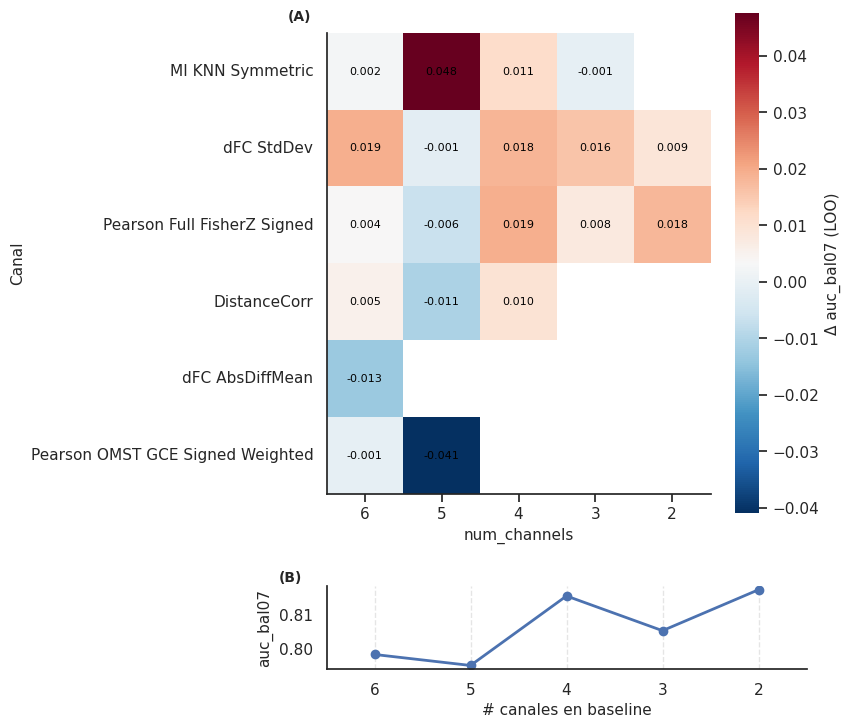

,num_channels,channel,rank_survival
0,2,dFC StdDev,5
1,3,MI KNN Symmetric,4
2,4,DistanceCorr,3
3,5,Pearson OMST GCE Signed Weighted,2
4,6,dFC AbsDiffMean,1


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
# 🎯  CELDA 3 – RFE HEATMAP + PERFORMANCE GLOBAL (alineación pixel‑perfecta)
# ──────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Estilo para paper
plt.rc("font", family="serif", size=10)
plt.rc("axes", titlesize=12, labelsize=11)
sns.set_style("white")

if not loo_df.empty:
    # ① Preparamos pivot y orden de columnas
    mean_imp = loo_df.groupby("channel")["impact"].mean()
    ordered_channels = mean_imp.sort_values(ascending=False).index
    pivot = (
        loo_df
        .pivot(index="channel", columns="num_channels", values="impact")
        .loc[ordered_channels]
        .sort_index(axis=1, ascending=False)
    )
    cols = pivot.columns.tolist()

    # ② Extraemos performance global en el mismo orden
    perf_global = rfe_df.set_index("num_channels")[scoring_metric].loc[cols]

    # ③ Parámetros de figura según tamaño pivote
    cell = 0.7
    nC, nR = pivot.shape[1], pivot.shape[0]
    fig_w = cell * nC + 2.5
    fig_h = cell * nR + 4

    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        figsize=(fig_w, fig_h),
        gridspec_kw={"height_ratios": [nR, 1], "hspace": 0.25},
        sharex=True
    )

    # ④ Calculamos ticks en el centro de cada celda
    xt = np.arange(len(cols)) + 0.5
    xlim = (xt[0] - 0.5, xt[-1] + 0.5)

    # — (A) Heatmap —
    sns.heatmap(
        pivot,
        annot=True, fmt=".3f",
        annot_kws={"fontsize":8, "color":"black"},
        cmap="RdBu_r",
        square=True,
        cbar_kws={"label": f"Δ {scoring_metric} (LOO)"},
        ax=ax1,
        xticklabels=False
    )
    ax1.set_ylabel("Canal")
    ax1.set_xlim(xlim)
    ax1.set_xticks(xt)
    ax1.set_xticklabels(cols, rotation=0, ha="center")
    ax1.xaxis.set_ticks_position("bottom")
    sns.despine(ax=ax1, left=False, bottom=False)
    ax1.text(-0.1, 1.02, "(A)", transform=ax1.transAxes,
             fontweight="bold", va="bottom")

    # — (B) Curva de performance —
    ax2.plot(xt, perf_global.values, marker="o", linewidth=2)
    ax2.set_xlim(xlim)
    ax2.set_xticks(xt)
    ax2.set_xticklabels(cols)
    ax2.set_xlabel("# canales en baseline")
    ax2.set_ylabel(scoring_metric)
    ax2.grid(axis="x", linestyle="--", alpha=0.5)
    sns.despine(ax=ax2, left=False, bottom=False)
    ax2.text(-0.1, 1.02, "(B)", transform=ax2.transAxes,
             fontweight="bold", va="bottom")

    # ⑤ Alineación exacta de márgenes y guardado
    fig.subplots_adjust(left=0.15, right=0.95, top=0.92, bottom=0.12)
    fig.align_xlabels()   # <--- eso alinea las etiquetas de X de ax1 y ax2

    plt.show()
    fig.savefig("fig_rfe_combined.pdf", dpi=300, format="pdf", bbox_inches="tight")

    # Ranking de “supervivencia”
    elim_step = (
        loo_df
        .sort_values(["num_channels", "impact"])
        .groupby("num_channels")
        .first()
        .reset_index()
    )
    elim_step["rank_survival"] = list(range(len(elim_step), 0, -1))
    display(elim_step[["num_channels", "channel", "rank_survival"]])
